In [1]:
import pandas as pd

# please use the dataset bank-additional.zip and extract it
df = pd.read_csv('C:/Users/hardi/Desktop/xgboost/lifespan_data_clean.csv')
print("ok")

ok


In [2]:
df.head()

,Age,Gender,Country,Exercise_hrs_per_week,Diet_Type,Medical_History,Work_Stress_Level,Smoking,Alcohol_Consumption,Social_Life,Sleep_hrs_per_day,BMI,Life_Expectancy
0,31,Male,Japan,2.2,Balanced,Cancers,High,Low,Low,High,4.2,16.9,66.01
1,55,Female,India,6.0,Balanced,Asthma,High,Low,Low,High,4.8,17.6,66.98
2,71,Female,France,11.8,Unhealthy,Asthma,High,Moderate,Low,Low,4.4,18.0,72.22
3,44,Female,India,9.2,Unhealthy,Asthma,Moderate,High,Moderate,Low,4.5,31.6,53.73
4,31,Male,Brazil,11.9,Healthy,Cancers,Low,Low,Never,Low,4.3,23.6,71.01


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Life_Expectancy')
y = df['Life_Expectancy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor

# Identify categorical and numerical columns
categorical_cols = ['Gender', 'Country', 'Diet_Type', 'Medical_History',
                    'Smoking', 'Alcohol_Consumption', 'Social_Life', 'Work_Stress_Level']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Define preprocessing steps
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

# Build pipeline
estimators = [
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=8))
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Country',
                                                   'Diet_Type',
                                                   'Medical_History', 'Smoking',
                                                   'Alcohol_Consumption',
                                                   'Social_Life',
                                                   'Work_Stress_Level']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age',
                                                   'Exercise_hrs_per_week',
                                                   'Sleep_hrs_per_day',
                                                   'BMI'])])),
                ('regressor',
                 XGBRegressor(base...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=8, ...))])

In [10]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define search space for XGBRegressor hyperparameters
search_space = {
    'regressor__max_depth': Integer(2, 8),
    'regressor__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'regressor__subsample': Real(0.5, 1.0),
    'regressor__colsample_bytree': Real(0.5, 1.0),
    'regressor__colsample_bylevel': Real(0.5, 1.0),
    'regressor__colsample_bynode': Real(0.5, 1.0),
    'regressor__reg_alpha': Real(0.0, 10.0),
    'regressor__reg_lambda': Real(0.0, 10.0),
    'regressor__gamma': Real(0.0, 10.0),
    'regressor__n_estimators': Integer(50, 500)
}

opt = BayesSearchCV(pipe, search_space, cv=3, n_iter=20, scoring='neg_mean_absolute_error', random_state=8, n_jobs=-1)

In [11]:
# Fit the model
opt.fit(X_train, y_train)

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('onehot',
                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                          ['Gender',
                                                                           'Country',
                                                                           'Diet_Type',
                                                                           'Medical_History',
                                                                           'Smoking',
                                                                           'Alcohol_Consumption',
                                                                           'Social_Life',
                                                                           'Work_Stress_Level']),
                                                                         ('scaler',
                                                                          StandardScaler(),
                                                                          ['Age',
                                                                           'Exercise_hrs_per_week',
                                                                           'Sleep_hrs_per_day',
                                                                           'BMI'])])),
                                        (...
                             'regressor__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'regressor__n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'regressor__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regressor__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'regressor__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [12]:
opt.best_estimator_


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Country',
                                                   'Diet_Type',
                                                   'Medical_History', 'Smoking',
                                                   'Alcohol_Consumption',
                                                   'Social_Life',
                                                   'Work_Stress_Level']),
                                                 ('scaler', StandardScaler(),
                                                  ['Age',
                                                   'Exercise_hrs_per_week',
                                                   'Sleep_hrs_per_day',
                                                   'BMI'])])),
                ('regressor',
                 XGBRegressor(base...
                              feature_types=None, gamma=0.0, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.24953195150235802, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=8, ...))])

In [13]:
abs(opt.best_score_)


np.float64(0.8452445665051306)

In [14]:
abs(opt.score(X_test, y_test))


0.7945665333557128

In [15]:
opt.predict(X_test)

array([71.5521  , 65.19196 , 85.32119 , 62.96244 , 62.90415 , 89.70995 ,
       52.472675, 35.701267, 78.29472 , 71.54914 , 60.42319 , 54.61291 ,
       66.21038 , 78.30028 , 73.902016, 74.2446  , 75.16291 , 75.52777 ,
       78.15145 , 58.548477, 80.03604 , 48.883823, 56.081806, 74.21614 ,
       64.77566 , 62.021793, 67.08183 , 66.2972  , 78.33187 , 55.074528,
       94.27669 , 60.184517, 70.39238 , 66.43831 , 70.56437 , 46.398926,
       76.060394, 75.517746, 59.8011  , 68.71631 , 78.81405 , 65.3172  ,
       74.35922 , 80.437965, 58.87301 , 61.856686, 49.424755, 91.14884 ,
       59.601734, 71.95443 , 88.315384, 67.89864 , 59.305767, 74.1658  ,
       75.204025, 65.41197 , 60.71743 , 73.14135 , 56.35252 , 60.01192 ,
       71.520645, 69.28164 , 69.069954, 62.920486, 84.044815, 82.896065,
       82.059555, 82.738914, 64.16078 , 86.26559 , 70.433395, 55.01521 ,
       67.55339 , 78.35032 , 92.52548 , 69.02138 , 81.91987 , 56.736824,
       66.36366 , 76.426254, 73.036934, 67.25369 , 

In [16]:
opt.best_estimator_.steps

[('preprocessor',
  ColumnTransformer(transformers=[('onehot',
                                   OneHotEncoder(handle_unknown='ignore'),
                                   ['Gender', 'Country', 'Diet_Type',
                                    'Medical_History', 'Smoking',
                                    'Alcohol_Consumption', 'Social_Life',
                                    'Work_Stress_Level']),
                                  ('scaler', StandardScaler(),
                                   ['Age', 'Exercise_hrs_per_week',
                                    'Sleep_hrs_per_day', 'BMI'])])),
 ('regressor',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=1.0, colsample_bynode=0.9967358252830325,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.0, grow_policy=None, importance_type=None,
               int

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

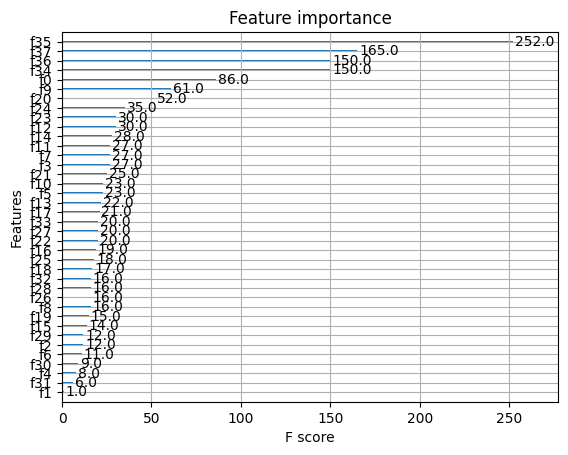

In [17]:
from xgboost import plot_importance

xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

In [18]:
import joblib

# Save the trained model
joblib.dump(opt.best_estimator_, "life_expectancy_model.pkl")
print("Model saved successfully!")


Model saved successfully!


In [19]:
# Load the saved model
loaded_model = joblib.load("life_expectancy_model.pkl")

# Make a test prediction (use a sample from X_test)
sample_input = X_test.iloc[[0]]  # Take the first row as an example
predicted_life_expectancy = loaded_model.predict(sample_input)

print(f"Predicted Life Expectancy: {predicted_life_expectancy[0]:.2f} years")


Predicted Life Expectancy: 71.55 years


In [20]:
print("Features used for training:", X_train.columns)


Features used for training: Index(['Age', 'Gender', 'Country', 'Exercise_hrs_per_week', 'Diet_Type',
       'Medical_History', 'Work_Stress_Level', 'Smoking',
       'Alcohol_Consumption', 'Social_Life', 'Sleep_hrs_per_day', 'BMI'],
      dtype='object')


In [4]:
import numpy as np
import pandas as pd
import joblib

# Load trained model
loaded_model = joblib.load("life_expectancy_model.pkl")

# Input data
data = {
    "Age": [60], 
    "Gender": ["Male"],
    "Country": ["Japan"],
    "Exercise_hrs_per_week": [7],
    "Diet_Type": ["Healthy"],
    "Work_Stress_Level": ["Moderate"],
    "Medical_History": ["Fit"],
    "Smoking": ["Never"],
    "Alcohol_Consumption": ["Never"],
    "Social_Life": ["Moderate"],
    "Sleep_hrs_per_day": [8],
    "BMI": [21]
}

# Convert input data to DataFrame
input_df = pd.DataFrame(data)

# Get prediction
predicted_life_expectancy = loaded_model.predict(input_df)[0]

if predicted_life_expectancy < data["Age"][0]:  
    predicted_life_expectancy = data["Age"][0] + np.random.uniform(2, 3)

print("Predicted Life Expectancy:", round(predicted_life_expectancy, 2))


Predicted Life Expectancy: 99.43
